Практическая работа №2 "Анализ логов"

Выполнил: Палаткин Андрей Андреевич ББМО-02-23


### Вариант
изображение.png

In [ ]:
variant = 46 % 16 + 1
print(f"Вариант {variant}")

Вариант 15


### Подключение библиотек



In [ ]:
import re
from datetime import datetime
# Библиотека для использования базы данных SQLite
import sqlite3
# Библиотека для удобной работы с табличными данными
import pandas as pd
# Библиотека для удобной визуализации данных
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dts

### Установка и открытие лог-файла


In [ ]:
# Скопируем репозиторий с github
!git clone https://github.com/logpai/loghub.git

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 575 (delta 146), reused 136 (delta 134), pack-reused 401
Receiving objects: 100% (575/575), 7.27 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [ ]:
windows_logs = open('/content/loghub/Windows/Windows_2k.log', 'r').readlines()
for log in windows_logs[:10]:
  print(log.replace('\n', ''))

2016-09-28 04:30:30, Info                  CBS    Loaded Servicing Stack v6.1.7601.23505 with Core: C:\Windows\winsxs\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_6.1.7601.23505_none_681aa442f6fed7f0\cbscore.dll
2016-09-28 04:30:31, Info                  CSI    00000001@2016/9/27:20:30:31.455 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fef9fb9b6d @0x7fef9f8358f @0xff83e97c @0xff83d799 @0xff83db2f)
2016-09-28 04:30:31, Info                  CSI    00000002@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa006ade @0x7fef9fd2984 @0x7fef9f83665 @0xff83e97c @0xff83d799)
2016-09-28 04:30:31, Info                  CSI    00000003@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa1c8728 @0x7fefa1c8856 @0xff83e474 @0xff83d7de @0xff83db2f)
2016-09-28 04:30:31, Info                  CBS    Ending TrustedInstaller initialization.
2016-09-28 04:30:31, Info     

Отдельная запись выглядит следующим образом:

Структура следующая:
```2016-09-28 04:30:30, Info                  CBS    Loaded Servicing Stack v6.1.7601.23505 with Core: C:\Windows\winsxs\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_6.1.7601.23505_none_681aa442f6fed7f0\cbscore.dll```
* **Дата в формате ГГГГ-ММ-ДД ЧАС:МИНУТА:СЕКУНДА**
* **Уровень логирования**
* **CBS или CSI**
* **Описание действия**

### Парсинг лог-файла

In [ ]:
# pattern = r'\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}'
windows_logs_normalized = []
for log in windows_logs:
  # date = datetime.strptime(log[0:19], '%Y-%m-%d %H:%M:%S')
  date = log[0:19]
  level = log[21:25]
  component = log[43:46]
  content = log[50:].replace('"', '').replace('\n', '')
  windows_logs_normalized.append([date, level, component, content])

for _ in windows_logs_normalized[:10]:
  print(_)

['2016-09-28 04:30:30', 'Info', 'CBS', 'Loaded Servicing Stack v6.1.7601.23505 with Core: C:\\Windows\\winsxs\\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_6.1.7601.23505_none_681aa442f6fed7f0\\cbscore.dll']
['2016-09-28 04:30:31', 'Info', 'CSI', '00000001@2016/9/27:20:30:31.455 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fef9fb9b6d @0x7fef9f8358f @0xff83e97c @0xff83d799 @0xff83db2f)']
['2016-09-28 04:30:31', 'Info', 'CSI', '00000002@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa006ade @0x7fef9fd2984 @0x7fef9f83665 @0xff83e97c @0xff83d799)']
['2016-09-28 04:30:31', 'Info', 'CSI', '00000003@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa1c8728 @0x7fefa1c8856 @0xff83e474 @0xff83d7de @0xff83db2f)']
['2016-09-28 04:30:31', 'Info', 'CBS', 'Ending TrustedInstaller initialization.']
['2016-09-28 04:30:31', 'Info', 'CBS', 'Starting the TrustedInstal

### Сохранение каждой записи в СУБД

In [ ]:
# Создание СУБД
connection = sqlite3.connect('logs.db')
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, datetime text, level text, component text, content text)")

# Внесение данных в СУБД
for _ in windows_logs_normalized:
  query = f'INSERT INTO logs (datetime, level, component, content) VALUES ("{_[0]}", "{_[1]}", "{_[2]}", "{_[3]}")'
  try:
    cursor.execute(query)
  except:
    print(query)

# Закрытие СУБД
connection.commit()
cursor.close()
connection.close()

# Открытие СУБД
connection = sqlite3.connect('logs.db')
cursor = connection.cursor()
cursor.execute("SELECT * FROM logs")
data = cursor.fetchall()
cursor.close()
connection.close()
pd_data = pd.DataFrame(data, columns=("i", "Время", "Уровень", "Компонент", "Содержание"))
pd_data

,i,Время,Уровень,Компонент,Содержание
0,1,2016-09-28 04:30:30,Info,CBS,Loaded Servicing Stack v6.1.7601.23505 with Co...
1,2,2016-09-28 04:30:31,Info,CSI,00000001@2016/9/27:20:30:31.455 WcpInitialize ...
2,3,2016-09-28 04:30:31,Info,CSI,00000002@2016/9/27:20:30:31.458 WcpInitialize ...
3,4,2016-09-28 04:30:31,Info,CSI,00000003@2016/9/27:20:30:31.458 WcpInitialize ...
4,5,2016-09-28 04:30:31,Info,CBS,Ending TrustedInstaller initialization.
...,...,...,...,...,...
1995,1996,2016-09-29 02:04:40,Info,CBS,Read out cached package applicability for pack...
1996,1997,2016-09-29 02:04:40,Info,CBS,Session: 30546354_3360174372 initialized by cl...
1997,1998,2016-09-29 02:04:40,Info,CBS,Read out cached package applicability for pack...
1998,1999,2016-09-29 02:04:40,Info,CBS,Session: 30546354_3363894584 initialized by cl...


### Визуализация результатов

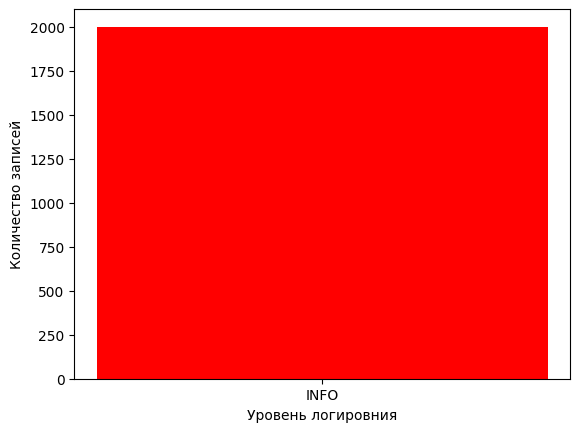

In [ ]:
# Подсчёт записей с различными уровнями логирования
pd_data_distrib = pd_data['Уровень'].value_counts()

x = pd_data_distrib.keys()
y = pd_data_distrib.values

# Заголовки для графика
verbose_xticks = ["INFO", "WARN"]

plt.xticks([0,1], verbose_xticks)
plt.xlabel('Уровень логировния')
plt.ylabel('Количество записей')
plt.bar(x,y)
plt.bar(x,y, color = ['red'])

plt.show()

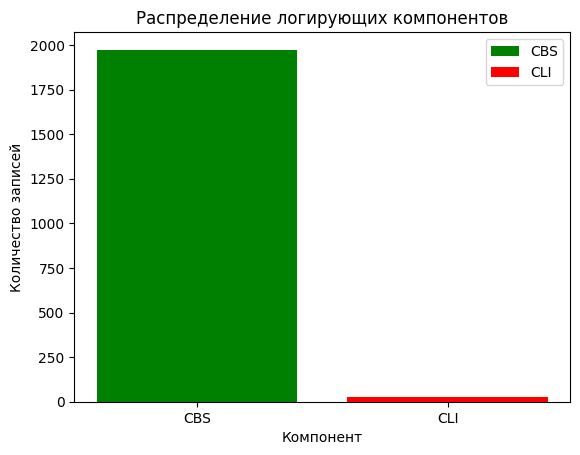

In [ ]:
import matplotlib.pyplot as plt

# Подсчёт логирующих компонентов
pd_data_distrib = pd_data['Компонент'].value_counts()

x = pd_data_distrib.index
y = pd_data_distrib.values

plt.title('Распределение логирующих компонентов')
plt.xticks([0, 1], ["CBS", "CLI"])

plt.xlabel('Компонент')
plt.ylabel('Количество записей')

bars = plt.bar(x, y, color=['green', 'red'])
plt.legend(bars, ['CBS', 'CLI'])

plt.show()


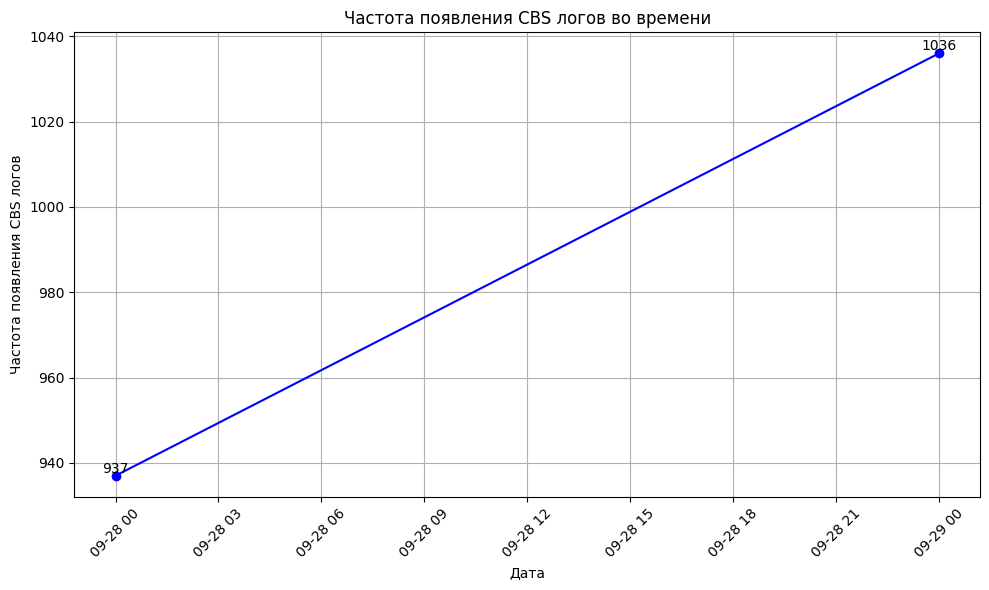

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Подготовка данных
cbs_df = pd_data[pd_data['Компонент'] == 'CBS'].copy()
cbs_df['Время'] = pd.to_datetime(cbs_df['Время'])
cbs_count = cbs_df.groupby(pd.Grouper(key='Время', freq='D')).size()

# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(cbs_count.index, cbs_count.values, linestyle='-', color='b', marker='o')

for x, y in zip(cbs_count.index, cbs_count.values):
    plt.text(x, y, f'{y}', ha='center', va='bottom')

plt.xlabel('Дата')
plt.ylabel('Частота появления CBS логов')
plt.title('Частота появления CBS логов во времени')

plt.xticks(rotation=45)  # Поворот меток по оси X
plt.grid(True)  # Добавление сетки
plt.tight_layout()  # Улучшение компактности графика

plt.show()



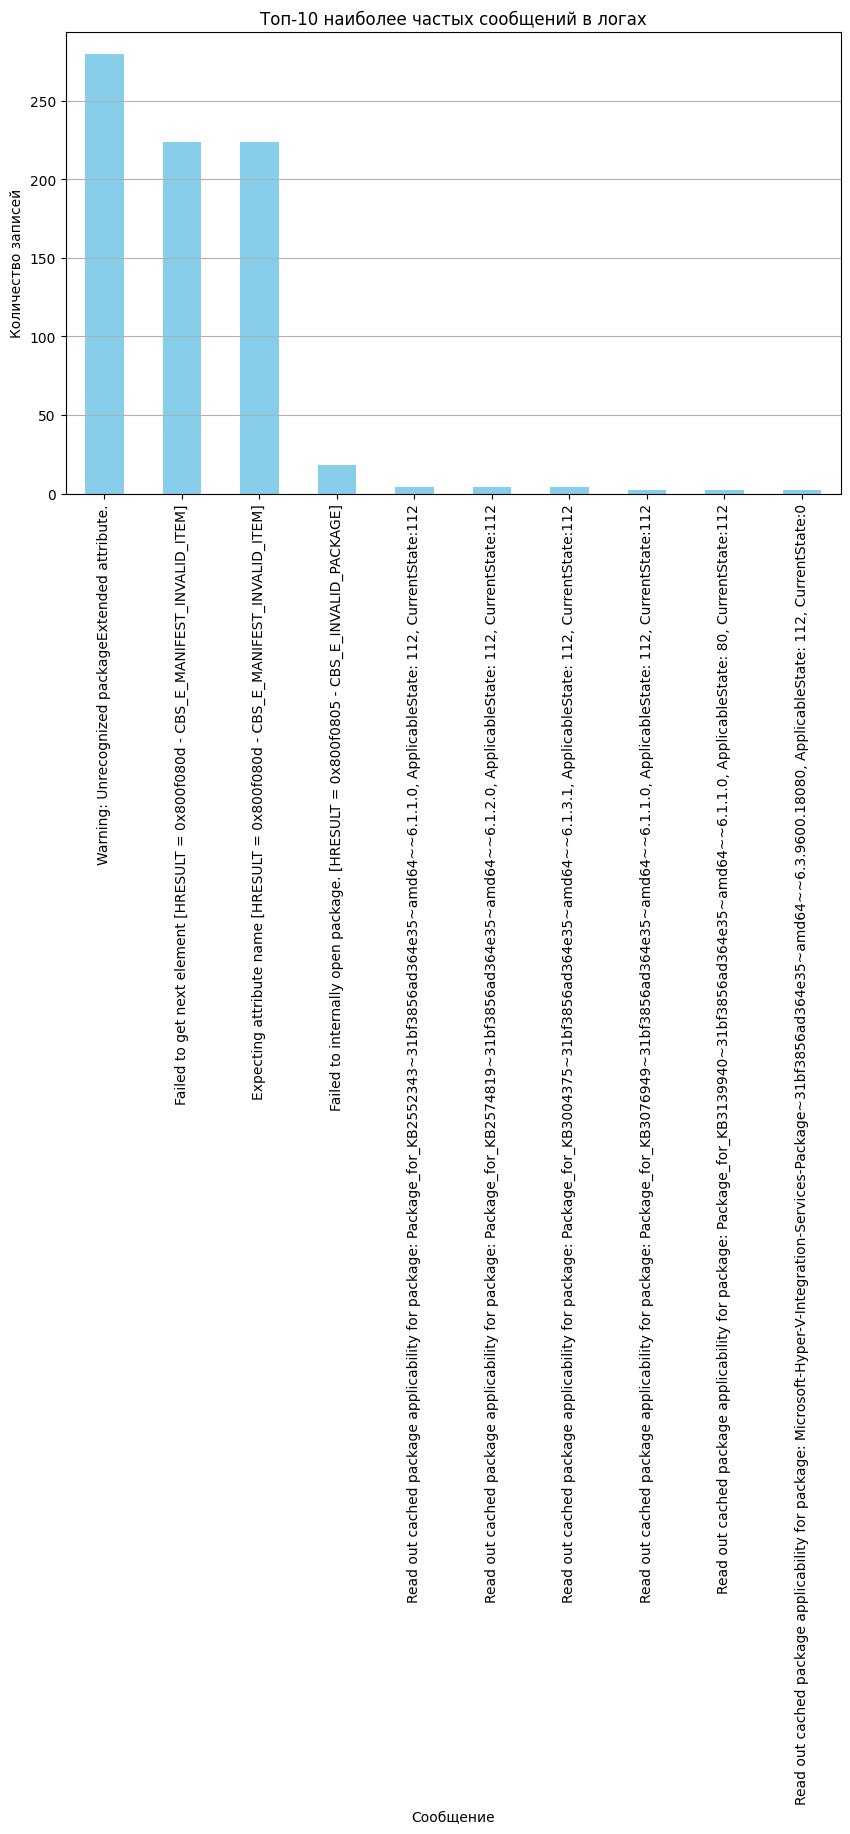

In [ ]:
import matplotlib.pyplot as plt

# Подсчёт наиболее частых сообщений в файле с логами
pd_data_distrib = pd_data['Содержание'].value_counts()[:10]

plt.figure(figsize=(10, 6))  # Устанавливаем размеры графика

# Построение графика
pd_data_distrib.plot(kind='bar', color='skyblue')

# Добавляем заголовок и метки осей
plt.title('Топ-10 наиболее частых сообщений в логах')
plt.xlabel('Сообщение')
plt.ylabel('Количество записей')

# Добавляем сетку для лучшей ориентации
plt.grid(axis='y')

# Показываем график
plt.show()
